In [9]:
# import library
import cv2
import matplotlib.pyplot as plt

In [10]:
def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn=frame.copy()
    frameHeight=frameOpencvDnn.shape[0]
    frameWidth=frameOpencvDnn.shape[1]
    blob=cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*frameWidth)
            y1=int(detections[0,0,i,4]*frameHeight)
            x2=int(detections[0,0,i,5]*frameWidth)
            y2=int(detections[0,0,i,6]*frameHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(frameOpencvDnn, (x1,y1), (x2,y2), (0,255,0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn,faceBoxes

In [11]:
# importing models
faceProto="opencv_face_detector.pbtxt"
faceModel="opencv_face_detector_uint8.pb"
ageProto="age_deploy.prototxt"
ageModel="age_net.caffemodel"
genderProto="gender_deploy.prototxt"
genderModel="gender_net.caffemodel"

In [12]:
MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)'] ## age list
genderList=['Male','Female'] ## gender list

In [13]:
# reads the model
faceNet=cv2.dnn.readNet(faceModel,faceProto)
ageNet=cv2.dnn.readNet(ageModel,ageProto)
genderNet=cv2.dnn.readNet(genderModel,genderProto)

Gender: Male
Age: 25-32 years


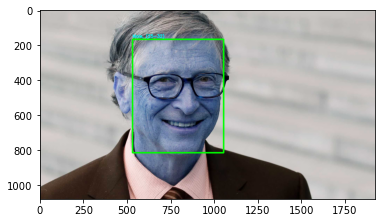

In [20]:
# for video
# video=cv2.VideoCapture("video.mp4")

# for webcam video
# video=cv2.VideoCapture(0)

# read an image
video=cv2.VideoCapture("bill_gates.jpg")

padding=20
while cv2.waitKey(1)<0:
    hasFrame,frame=video.read()
    if not hasFrame:
        cv2.waitKey()
        break

    resultImg,faceBoxes=highlightFace(faceNet,frame)
    if not faceBoxes:
        print("No face detected")

    for faceBox in faceBoxes:
        face=frame[max(0,faceBox[1]-padding):
                   min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding)
                   :min(faceBox[2]+padding, frame.shape[1]-1)]

        blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds=genderNet.forward()
        gender=genderList[genderPreds[0].argmax()]
        print(f'Gender: {gender}')

        ageNet.setInput(blob)
        agePreds=ageNet.forward()
        age=ageList[agePreds[0].argmax()]
        print(f'Age: {age[1:-1]} years')
        
        # print age and gender of image 
        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)
        cv2.imshow("Detecting age and gender", resultImg)
        plt.imshow(resultImg)# bgr

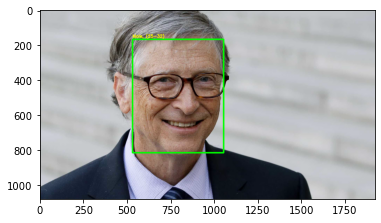

In [21]:
plt.imshow(cv2.cvtColor(resultImg, cv2.COLOR_BGR2RGB)) ## convert bgr to rgb